# harm_take2
## Purpose: Learn how to use the aneris tool for harmonization
Struggling with aneris... take 2 based on Smith script
- Historical (1750-2022) and projected (2020-2100) emissions datasets
    - Historical dataset is product of PRIMAP, CEDS, GCP, & GFED
    - Projected datasets are outputs of GCAM 6.0 NGFS and MESSAGEix-GLOBIOM (will focus on one at a time)
    
    
Credit: 
- Gidden, M. (2017). gidden/aneris: Initial release version for harmonization paper (v0.1.0). Zenodo. https://doi.org/10.5281/ZENODO.802832
- https://github.com/chrisroadmap/fair-calibrate/blob/main/input/fair-2.1.3/v1.4/all-2022/calibration/12_harmonize-emissions.py


## Erica Simon, 02/02/24

In [295]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import aneris
import aneris.convenience
from tqdm.auto import tqdm

import datetime
import os
import warnings

## Import datasets

In [296]:
MSG_df = pd.read_csv('~/outputs/NGFS_MSG_interp.csv')
GCAM_df = pd.read_csv('~/outputs/NGFS_GCAM_interp.csv')
hist_df = pd.read_csv('~/outputs/hist_emis_ALL.csv')

## Harmonize
This section of code adapted from https://github.com/chrisroadmap/fair-calibrate/blob/main/input/fair-2.1.3/v1.4/all-2022/calibration/12_harmonize-emissions.py

### set overrides

In [297]:
# Harmonization overrides - use same as RCMIP
overrides = pd.DataFrame(
    [
        {
            "method": "reduce_ratio_2150_cov",
            "variable": "Emissions|C2F6",
        },  # high historical variance (cov=16.2)
        {
            "method": "reduce_ratio_2150_cov",
            "variable": "Emissions|C6F14",
        },  # high historical variance (cov=15.4)
        {
            "method": "reduce_ratio_2150_cov",
            "variable": "Emissions|CF4",
        },  # high historical variance (cov=11.2)
        {
            "method": "reduce_ratio_2150_cov",
            "variable": "Emissions|CO",
        },  # high historical variance (cov=15.4)
        {
            "method": "reduce_ratio_2080",
            "variable": "Emissions|CO2",
        },  # always ratio method by choice
        {
            "method": "reduce_offset_2150_cov",
            "variable": "Emissions|CO2 AFOLU",
        },  # high historical variance, but using offset method to prevent diff from
        # increasing when going negative rapidly (cov=23.2)
        {
            "method": "reduce_ratio_2080",  # always ratio method by choice
            "variable": "Emissions|CO2 FFI",
        },
        #     {'method': 'default_aneris_tree', 'variable': 'Emissions|CH4'},
        # depending on the decision tree in aneris/method.py
        {
            "method": "constant_ratio",
            "variable": "Emissions|HFC-125",
        },  # minor f-gas with low model reporting confidence
        {
            "method": "constant_ratio",
            "variable": "Emissions|HFC-134a",
        },  # minor f-gas with low model reporting confidence
        {
            "method": "constant_ratio",
            "variable": "Emissions|HFC-143a",
        },  # minor f-gas with low model reporting confidence
        {
            "method": "constant_ratio",
            "variable": "Emissions|HFC-227ea",
        },  # minor f-gas with low model reporting confidence
        {
            "method": "constant_ratio",
            "variable": "Emissions|HFC-23",
        },  # minor f-gas with low model reporting confidence
        {
            "method": "constant_ratio",
            "variable": "Emissions|HFC-32",
        },  # minor f-gas with low model reporting confidence
        {
            "method": "constant_ratio",
            "variable": "Emissions|HFC-4310mee",
        },  # minor f-gas with low model reporting confidence
        #     {'method': 'default_aneris_tree', 'variable': 'Emissions|N2O'},
        # depending on the decision tree in aneris/method.py
        #     {'method': 'default_aneris_tree', 'variable': 'Emissions|NH3'},
        # depending on the decision tree in aneris/method.py
        #     {'method': 'default_aneris_tree', 'variable': 'Emissions|NOx'},
        # depending on the decision tree in aneris/method.py
        {
            "method": "reduce_ratio_2150_cov",
            "variable": "Emissions|OC",
        },  # high historical variance (cov=18.5)
        {
            "method": "constant_ratio",
            "variable": "Emissions|SF6",
        },  # minor f-gas with low model reporting confidence
        #     {'method': 'default_aneris_tree', 'variable': 'Emissions|Sulfur'},
        # depending on the decision tree in aneris/method.py
        {
            "method": "reduce_ratio_2150_cov",
            "variable": "Emissions|VOC",
        },  # high historical variance (cov=12.0)
    ]
)

we need to remove the override for HFC-23 in the MESSAGE IAM because has all emissions at 0 for this specie

In [298]:
MSG_overrides = overrides[~(overrides.variable == 'Emissions|HFC-23')]

### run harmonizer

In [299]:
progress = os.getenv("PROGRESS", "False").lower() in ("true", "1", "t")

In [300]:
def harmonize(hist, future, harm_yr, overrides):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        scenarios_harmonized = [
            aneris.convenience.harmonise_all(
                msdf,
                history=hist,
                year=harm_yr,
                overrides=overrides,
            )
            for _, msdf in tqdm(future.groupby(["Model", "Scenario"]), disable=1 - progress)
        ]

    scenarios_harmonized = pd.concat(scenarios_harmonized).reset_index()
    return scenarios_harmonized

In [301]:
GCAM_harm = harmonize(hist_df, GCAM_df, 2022, overrides)
MSG_harm = harmonize(hist_df, MSG_df, 2022, MSG_overrides)

pyam.core - WARNING: Filtered IamDataFrame is empty!
INFO:root:Harmonizing with reduce_ratio_2080
INFO:root:Harmonizing with reduce_ratio_2150_cov
INFO:root:Harmonizing with reduce_offset_2150_cov
INFO:root:Harmonizing with constant_ratio
pyam.core - WARNING: Filtered IamDataFrame is empty!
INFO:root:Harmonizing with reduce_ratio_2080
INFO:root:Harmonizing with reduce_ratio_2150_cov
INFO:root:Harmonizing with reduce_offset_2150_cov
INFO:root:Harmonizing with constant_ratio
pyam.core - WARNING: Filtered IamDataFrame is empty!
INFO:root:Harmonizing with reduce_ratio_2080
INFO:root:Harmonizing with reduce_ratio_2150_cov
INFO:root:Harmonizing with reduce_offset_2150_cov
INFO:root:Harmonizing with constant_ratio
pyam.core - WARNING: Filtered IamDataFrame is empty!
INFO:root:Harmonizing with reduce_ratio_2080
INFO:root:Harmonizing with reduce_ratio_2150_cov
INFO:root:Harmonizing with reduce_offset_2150_cov
INFO:root:Harmonizing with constant_ratio
pyam.core - WARNING: Filtered IamDataFrame i

### save harmonized data

In [302]:
GCAM_harm.to_csv('~/outputs/GCAM_harm.csv', index=False)
MSG_harm.to_csv('~/outputs/MSG_harm.csv', index=False)

## Visualize

In [303]:
def plot_harm(hist, future, harm_ized, var, scen):
    histt = hist.loc[hist.Variable == 'Emissions|'+var].values[0][255:]
    raw = future.loc[future.Variable == 'Emissions|'+var].loc[future.Scenario == scen].values[0][7:]
    harm = harm_ized.loc[harm_ized.variable == 'Emissions|'+var].loc[harm_ized.scenario == scen].values[0][5:]
    unit = hist.loc[hist.Variable == 'Emissions|'+var].values[0][4]
    mdl = harm_ized.model.values[0]
    
    plt.plot(np.arange(2000, 2023), histt)
    plt.plot(np.arange(2022, 2101), raw, label='unharmonized')
    plt.plot(np.arange(2022, 2101), harm, label='harmonized')
    plt.axvline(2022, linestyle='--', color='grey', alpha=0.5)
    plt.xlabel('Year')
    plt.ylabel(unit)
    plt.title('Harmonized '+var+' Emissions\n'+scen+' Scenario\n'+mdl)
    plt.legend()
    plt.show()

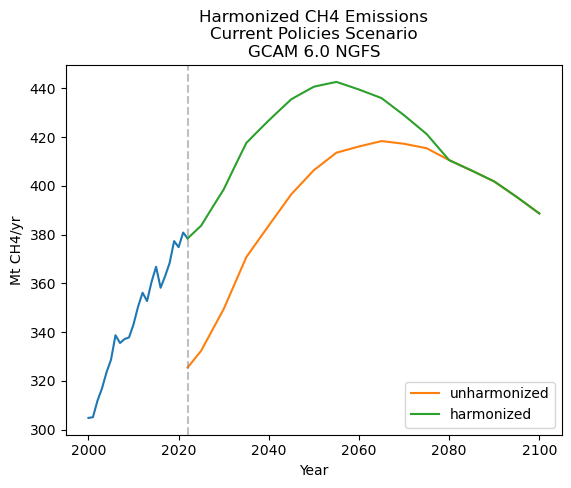

In [304]:
plot_harm(hist_df, GCAM_df, GCAM_harm, 'CH4', 'Current Policies')

# check unit adjustment

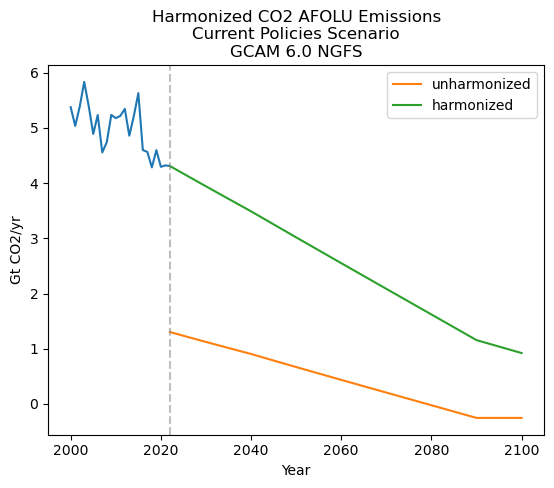

In [305]:
plot_harm(hist_df, GCAM_df, GCAM_harm, 'CO2 AFOLU', 'Current Policies')

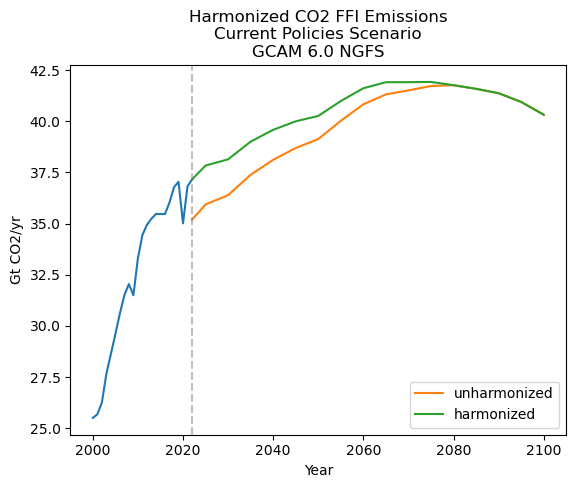

In [306]:
plot_harm(hist_df, GCAM_df, GCAM_harm, 'CO2 FFI', 'Current Policies')

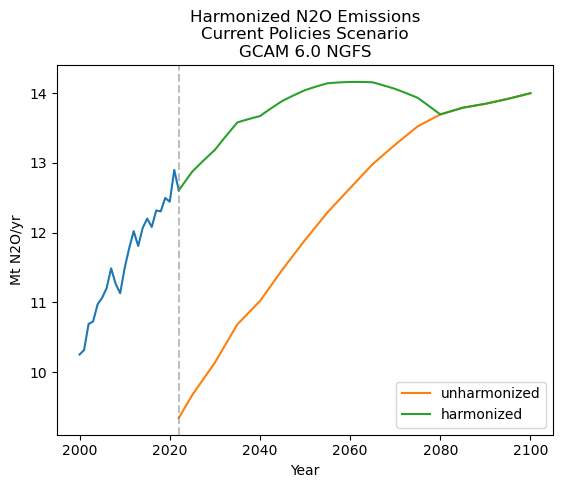

In [307]:
plot_harm(hist_df, GCAM_df, GCAM_harm, 'N2O', 'Current Policies')

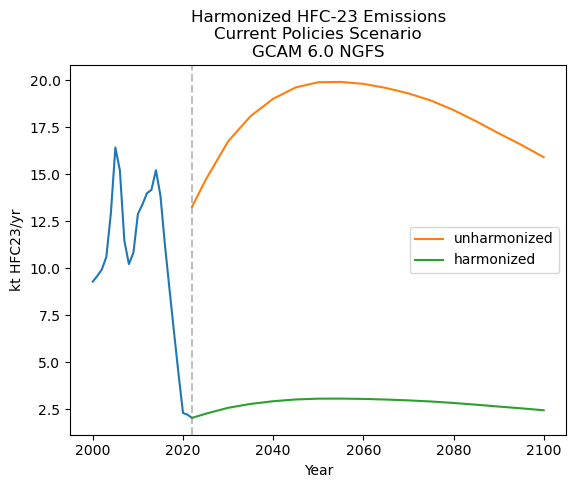

In [308]:
plot_harm(hist_df, GCAM_df, GCAM_harm, 'HFC-23', 'Current Policies')

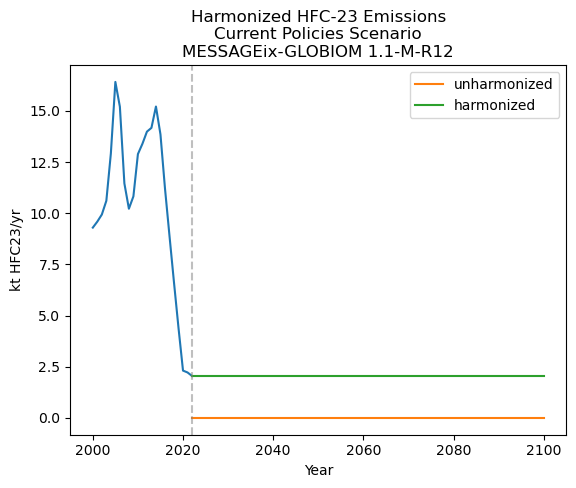

In [309]:
plot_harm(hist_df, MSG_df, MSG_harm, 'HFC-23', 'Current Policies')